Import the libraries

In [2]:
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(7,4), 'figure.dpi':80})
import warnings 
warnings.filterwarnings('ignore')

Import the dataset

In [3]:
df=pd.read_csv('Electric_Production.csv')
df.head()

,DATE,Value
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [4]:
df.tail()

,DATE,Value
392,9/1/2017,98.6154
393,10/1/2017,93.6137
394,11/1/2017,97.3359
395,12/1/2017,114.7212
396,1/1/2018,129.4048


In [5]:
df.shape

(397, 2)

making the data variable index and then transform

In [6]:
df.set_index('DATE',inplace=True)
df.index=pd.to_datetime(df.index)
#drop null values
df.dropna(inplace=True)


In [7]:
df

,Value
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151
...,...
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359


Plotting the whole time series data

<AxesSubplot:xlabel='DATE'>

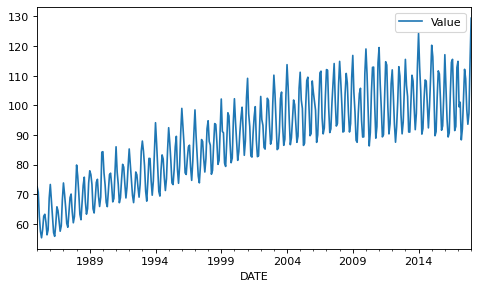

In [8]:
df.plot()

plotting the first 30 months of electricity production to see the seasons present

<AxesSubplot:xlabel='DATE'>

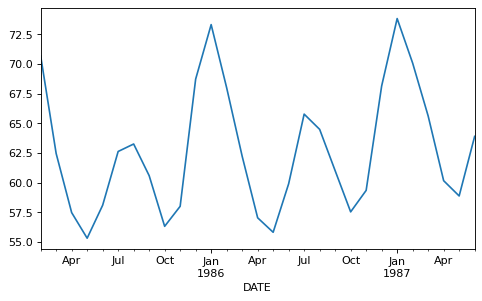

In [9]:
df.Value[1:30].plot()

import the libraries for time series analysis

In [12]:
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

Decompose the time series bto see the frend and seasonal components

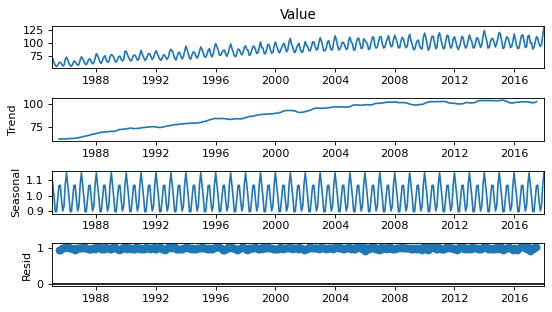

In [13]:
result=seasonal_decompose(df['Value'],  model='multiplicable')
result.plot()
plt.show()

<AxesSubplot:xlabel='DATE'>

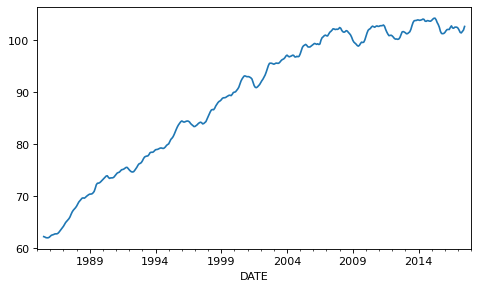

In [14]:
result.trend.plot()

<AxesSubplot:xlabel='DATE'>

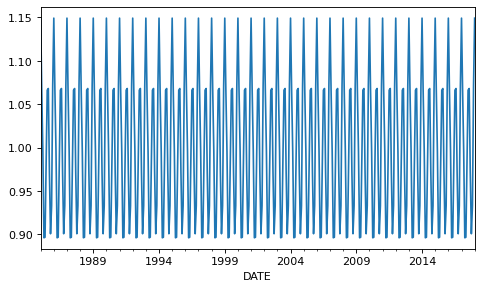

In [15]:
result.seasonal.plot()

Exploring the TS data for stationarity aspect

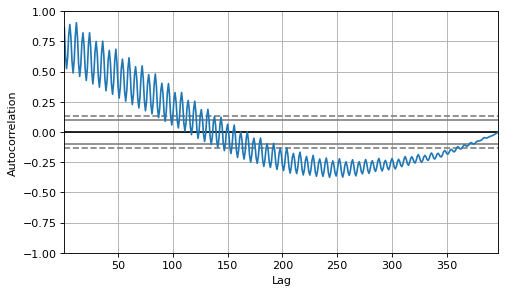

the data is non stationary


In [28]:
autocorrelation_plot(df)
plt.show()
print('the data is non stationary')

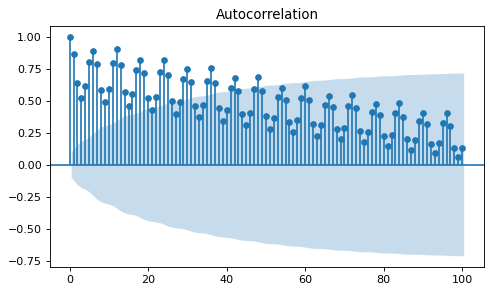

In [29]:
plot_acf(df, lags=100)
plt.show()

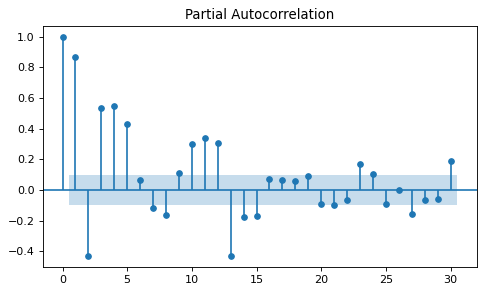

In [30]:
plot_pacf(df, lags=30)
plt.show()

In [31]:
result=adfuller(df['Value'])
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
for value,label in zip(result,labels):
    print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

ADF Test Statistic : -2.2569903500472326
p-value : 0.18621469116587192
#Lags Used : 15
Number of Observations : 381
weak evidence against null hypothesis,indicating it is non-stationary 


Differentiate the data to make it stationary

In [32]:
df['Value diff'] = df['Value'].diff()
df.head()

,Value,Value diff
DATE,,
1985-01-01,72.5052,NaN
1985-02-01,70.6720,-1.8332
1985-03-01,62.4502,-8.2218
1985-04-01,57.4714,-4.9788
1985-05-01,55.3151,-2.1563


In [33]:
result=adfuller(df['Value diff'].dropna())
labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
for value,label in zip(result,labels):
    print(label+' : '+str(value) )

if result[1] <= 0.05:
    print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
else:
    print("weak evidence against null hypothesis,indicating it is non-stationary ")

ADF Test Statistic : -7.104890882267305
p-value : 4.077786565539574e-10
#Lags Used : 14
Number of Observations : 381
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


In [34]:
# Again testing if data is stationary
adfuller(df['Value diff'].dropna())

(-7.104890882267305,
 4.077786565539574e-10,
 14,
 381,
 {'1%': -3.4476305904172904,
  '5%': -2.869155980820355,
  '10%': -2.570827146203181},
 1840.5415092614141)

<AxesSubplot:xlabel='DATE'>

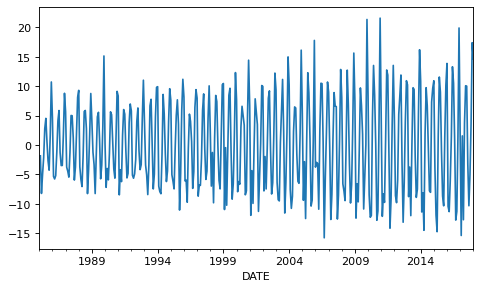

In [35]:
df['Value diff'].plot()

split the TS data into a training and validation set

In [36]:
train = df[:int(0.65*(len(df)))]
valid = df[int(0.65*(len(df))):]

<AxesSubplot:xlabel='DATE'>

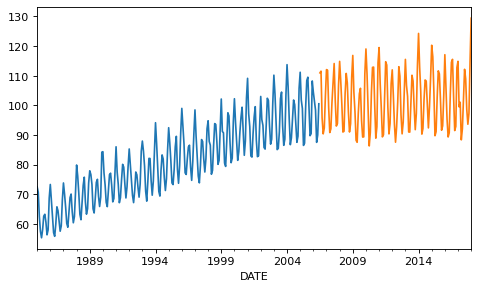

In [37]:
#plotting the data
train['Value'].plot()
valid['Value'].plot()

In [38]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
from pmdarima.arima import AutoARIMA

In [39]:
#building the model
arima_model = pm.auto_arima(train.Value)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  258
Model:               SARIMAX(1, 1, 5)   Log Likelihood                -721.094
Date:                Thu, 24 Jun 2021   AIC                           1458.187
Time:                        10:02:15   BIC                           1486.580
Sample:                             0   HQIC                          1469.605
                                - 258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0994      0.026      3.788      0.000       0.048       0.151
ar.L1          0.3495      0.135      2.594      0.009       0.085       0.614
ma.L1         -0.4565      0.118     -3.859      0.000      -0.688      -0.225
ma.L2         -0.6579      0.068     -9.671      0.000      -0.791      -0.525
ma.L3         -0.3384      0.108     -3.130      0.002      -0.550      -0.126
ma.L4          0.0760      0.071      1.067      0.286      -0.064       0.216
ma.L5          0.4234      0.068      6.262      0.000       0.291       0.556
sigma2        15.7698      1.471     10.723      0.000      12.887      18.652
===================================================================================
Ljung-Box (L1) (Q):                   1.07   Jarque-Bera (JB):                 1.02
Prob(Q):                              0.30   Prob(JB):                         0.60
Heteroskedasticity (H):               2.07   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [40]:
forecasts = arima_model.predict(n_periods=valid.shape[0])
valid['forecasts'] = forecasts
valid.head()

,Value,Value diff,forecasts
DATE,,,
2006-07-01,110.9503,10.4259,108.295569
2006-08-01,111.5192,0.5689,107.903697
2006-09-01,95.7632,-15.7560,101.574884
2006-10-01,90.3738,-5.3894,98.986114
2006-11-01,92.3566,1.9828,100.149296


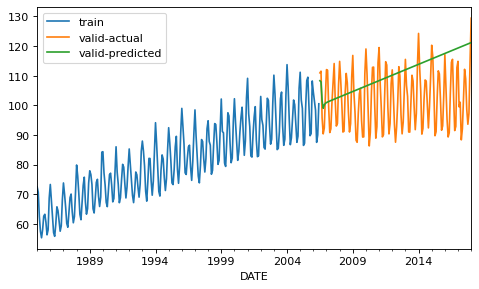

In [41]:
train["Value"].plot()
valid["Value"].plot()
valid["forecasts"].plot()
labels = ['train', 'valid-actual', 'valid-predicted']
plt.legend(labels)

In [42]:
MAE = mean_absolute_error(valid['Value'], valid.forecasts)
RMSE = math.sqrt(mean_squared_error(valid['Value'], valid.forecasts))

print("Mean Absolute Error: {:.3f}".format(MAE))
print("Root Mean Squared Error: {:.3f}".format(RMSE))

Mean Absolute Error: 11.351
Root Mean Squared Error: 13.778


Building arima model with seasonality

In [43]:
arima_model_seasonal = pm.auto_arima(train['Value'], seasonal=True, m=6)
arima_model_seasonal.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  258
Model:             SARIMAX(1, 1, 1)x(2, 0, [1, 2], 6)   Log Likelihood                -558.466
Date:                                Thu, 24 Jun 2021   AIC                           1130.931
Time:                                        10:10:37   BIC                           1155.775
Sample:                                             0   HQIC                          1140.922
                                                - 258                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5336      0.052     10.310      0.000       0.432       0.635
ma.L1         -0.9770      0.024    -40.254      0.000      -1.025      -0.929
ar.S.L6        0.0063      0.008      0.831      0.406      -0.008       0.021
ar.S.L12       0.9902      0.008    125.814      0.000       0.975       1.006
ma.S.L6        0.0644      0.067      0.965      0.335      -0.066       0.195
ma.S.L12      -0.7009      0.068    -10.250      0.000      -0.835      -0.567
sigma2         4.0004      0.250     15.970      0.000       3.509       4.491
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                83.99
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [44]:
forecasts = arima_model_seasonal.predict(n_periods=valid.shape[0])
valid['forecasts'] = forecasts
valid.head()

,Value,Value diff,forecasts
DATE,,,
2006-07-01,110.9503,10.4259,107.242422
2006-08-01,111.5192,0.5689,107.693008
2006-09-01,95.7632,-15.7560,98.835206
2006-10-01,90.3738,-5.3894,91.274959
2006-11-01,92.3566,1.9828,93.204731


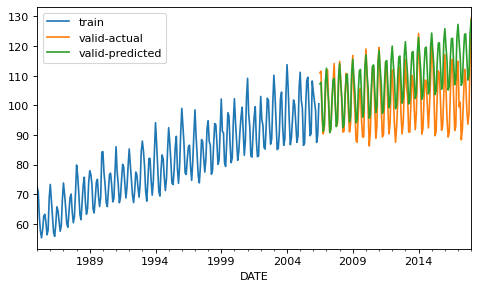

In [45]:
train["Value"].plot()
valid["Value"].plot()
valid["forecasts"].plot()
labels = ['train', 'valid-actual', 'valid-predicted']
plt.legend(labels)

In [46]:
MAE = mean_absolute_error(valid['Value'], valid.forecasts)
RMSE = math.sqrt(mean_squared_error(valid['Value'], valid.forecasts))

print("Mean Absolute Error: {:.3f}".format(MAE))
print("Root Mean Squared Error: {:.3f}".format(RMSE))

Mean Absolute Error: 7.468
Root Mean Squared Error: 9.016


In [47]:
arima_model_seasonal_12 = pm.auto_arima(train['Value'], seasonal=True, m=12)
arima_model_seasonal_12.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  258
Model:             SARIMAX(1, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -524.037
Date:                              Thu, 24 Jun 2021   AIC                           1056.074
Time:                                      10:15:44   BIC                           1070.095
Sample:                                           0   HQIC                          1061.719
                                              - 258                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.8374      0.117      7.174      0.000       0.609       1.066
ar.L1          0.5385      0.056      9.658      0.000       0.429       0.648
ma.S.L12      -0.6988      0.061    -11.482      0.000      -0.818      -0.580
sigma2         4.0089      0.232     17.274      0.000       3.554       4.464
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               116.57
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
forecasts = arima_model_seasonal_12.predict(n_periods=valid.shape[0])
valid['forecasts'] = forecasts
valid.head()

,Value,Value diff,forecasts
DATE,,,
2006-07-01,110.9503,10.4259,108.292630
2006-08-01,111.5192,0.5689,108.750242
2006-09-01,95.7632,-15.7560,99.570574
2006-10-01,90.3738,-5.3894,92.266106
2006-11-01,92.3566,1.9828,93.990654


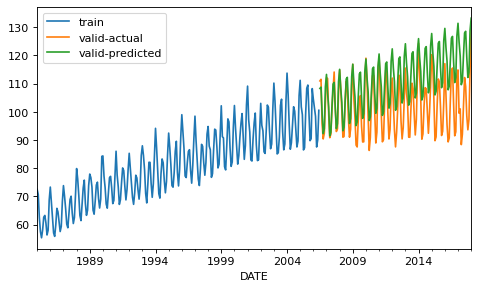

In [49]:
train["Value"].plot()
valid["Value"].plot()
valid["forecasts"].plot()
labels = ['train', 'valid-actual', 'valid-predicted']
plt.legend(labels)

In [50]:
MAE = mean_absolute_error(valid['Value'], valid.forecasts)
RMSE = math.sqrt(mean_squared_error(valid['Value'], valid.forecasts))

print("Mean Absolute Error: {:.3f}".format(MAE))
print("Root Mean Squared Error: {:.3f}".format(RMSE))

Mean Absolute Error: 9.417
Root Mean Squared Error: 11.140
